In [106]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import iqr


In [64]:
df=pd.io.gbq.read_gbq('SELECT * FROM projekt-zaliczeniowy-401114.movies.movies',project_id='projekt-zaliczeniowy-401114')

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Poster_Link      1000 non-null   object 
 1   Series_Title     1000 non-null   object 
 2   Released_Year    1000 non-null   Int64  
 3   Certificate      899 non-null    object 
 4   IMDB_Rating      1000 non-null   float64
 5   Overview         1000 non-null   object 
 6   Meta_score       843 non-null    float64
 7   Director         1000 non-null   object 
 8   Star1            1000 non-null   object 
 9   Star2            1000 non-null   object 
 10  Star3            1000 non-null   object 
 11  Star4            1000 non-null   object 
 12  No_of_Votes      1000 non-null   Int64  
 13  Gross            831 non-null    float64
 14  Runtime_minutes  1000 non-null   Int64  
 15  Genre1           1000 non-null   object 
 16  Genre2           895 non-null    object 
 17  Genre3         

In [9]:
df.head()

,Poster_Link,Series_Title,Released_Year,Certificate,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Runtime_minutes,Genre1,Genre2,Genre3
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0,142,Drama,None,None
1,https://m.media-amazon.com/images/M/MV5BMmEzNT...,Fight Club,1999,A,8.8,An insomniac office worker and a devil-may-car...,66.0,David Fincher,Brad Pitt,Edward Norton,Meat Loaf,Zach Grenier,1854740,37030102.0,139,Drama,None,None
2,https://m.media-amazon.com/images/M/MV5BZjA0OW...,One Flew Over the Cuckoo's Nest,1975,A,8.7,A criminal pleads insanity and is admitted to ...,83.0,Milos Forman,Jack Nicholson,Louise Fletcher,Michael Berryman,Peter Brocco,918088,112000000.0,133,Drama,None,None
3,https://m.media-amazon.com/images/M/MV5BOTc2ZT...,Soorarai Pottru,2020,U,8.6,"Nedumaaran Rajangam ""Maara"" sets out to make t...",NaN,Sudha Kongara,Suriya,Madhavan,Paresh Rawal,Aparna Balamurali,54995,NaN,153,Drama,None,None
4,https://m.media-amazon.com/images/M/MV5BZjA0MT...,American History X,1998,R,8.5,A former neo-nazi skinhead tries to prevent hi...,62.0,Tony Kaye,Edward Norton,Edward Furlong,Beverly D'Angelo,Jennifer Lien,1034705,6719864.0,119,Drama,None,None


## Outliers analysis

Outlier analysis is the process of identifying outliers, or abnormal observations, in a dataset. Also known as outlier detection, it’s an important step in data analysis, as it removes erroneous or inaccurate observations which might otherwise skew conclusions and bias the results. In our case we will use IQR rule to detect the outliers.

IQR is the range between the first and the third quartiles namely Q1 and Q3: IQR = Q3 – Q1. The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers.

In [149]:
def outliers_detection(dataframe):
    """ A function that return tuple with dictionary that contains number of outliers for every column and
        a data frame with the value True/False if the observation is an outlier"""
    dict_of_outliers = dict()
    dataframe_copy = dict()
    for col in dataframe.columns:
        if dataframe[col].dtype != "object":
            dataframe[col].fillna(dataframe[col].mean(), inplace = True)
            inter_quartile = iqr(dataframe[col])
            lower_boundary = np.quantile(dataframe[col], 0.25) - (1.5 * inter_quartile)
            upper_boundary = np.quantile(dataframe[col], 0.75) + (1.5 * inter_quartile)
            num_outliers = dataframe[col].where((dataframe[col] < lower_boundary) | (dataframe[col] > upper_boundary)).count()
            dict_of_outliers[col] = num_outliers
            dataframe_copy[col] = ~dataframe[col].where((dataframe[col] < lower_boundary) | (dataframe[col] > upper_boundary)).isna()
    return dict_of_outliers, pd.DataFrame(dataframe_copy)


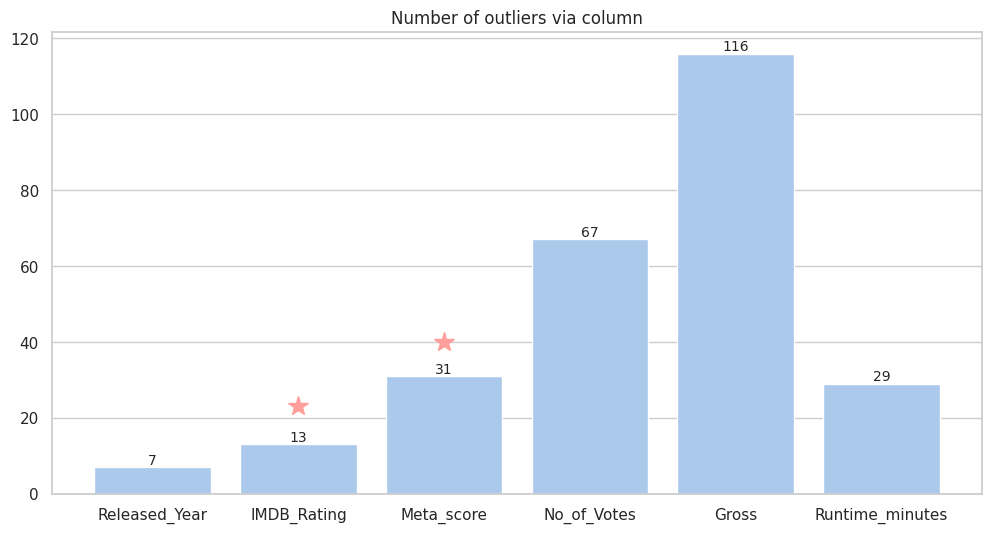

In [150]:
# Execute the function on our initial data frame  
outliers = outliers_detection(df)[0]
# Visualization of the number of outliers
fig, ax = plt.subplots(figsize = (12,6))
sns.set(style = "whitegrid", palette = "pastel", color_codes = True)
sns.barplot(outliers, ax = ax)
ax.set_title("Number of outliers via column")
ax.bar_label(ax.containers[0], fontsize=10)
ax.plot("Meta_score", 40, "*", markersize = 15, color = "r")
ax.plot("IMDB_Rating", 23, "*", markersize=15, color="r")
plt.show()

In this report we will focus on IMDB_Rating and Meta_score outliers. It is important to detect observations which have significantly different ratings. Let's then find observations which are outliers in IMDB_Rating or Meta_score rating.

In [101]:
is_outlier = outliers_detection(df)[1]
outliers_idx = is_outlier.query('(IMDB_Rating == True) | (Meta_score == True)').index
imdb_or_meta_outliers = df.iloc[outliers_idx]
print(f"There are {len(imdb_or_meta_outliers)} outliers!")
display(imdb_or_meta_outliers.head())

There are 44 outliers!


,Poster_Link,Series_Title,Released_Year,Certificate,IMDB_Rating,Overview,Meta_score,Director,Star1,Star2,Star3,Star4,No_of_Votes,Gross,Runtime_minutes,Genre1,Genre2,Genre3
0,https://m.media-amazon.com/images/M/MV5BMDFkYT...,The Shawshank Redemption,1994,A,9.3,Two imprisoned men bond over a number of years...,80.0,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,2343110,28341469.0,142,Drama,None,None
1,https://m.media-amazon.com/images/M/MV5BMmEzNT...,Fight Club,1999,A,8.8,An insomniac office worker and a devil-may-car...,66.0,David Fincher,Brad Pitt,Edward Norton,Meat Loaf,Zach Grenier,1854740,37030102.0,139,Drama,None,None
31,https://m.media-amazon.com/images/M/MV5BMTUyMT...,My Name Is Khan,2010,UA,8.0,An Indian Muslim man with Asperger's syndrome ...,50.0,Karan Johar,Shah Rukh Khan,Kajol,Sheetal Menon,Katie A. Keane,98575,4018695.0,165,Drama,None,None
63,https://m.media-amazon.com/images/M/MV5BMTM3Nz...,Detachment,2011,None,7.7,A substitute teacher who drifts from classroom...,52.0,Tony Kaye,Adrien Brody,Christina Hendricks,Marcia Gay Harden,Lucy Liu,77071,71177.0,98,Drama,None,None
67,https://m.media-amazon.com/images/M/MV5BYzEyNz...,I Am Sam,2001,PG-13,7.7,A mentally handicapped man fights for custody ...,28.0,Jessie Nelson,Sean Penn,Michelle Pfeiffer,Dakota Fanning,Dianne Wiest,142863,40311852.0,132,Drama,None,None


We will visualize the outliers among all observations on a IMDB_rating - Meta_score scatter plot.

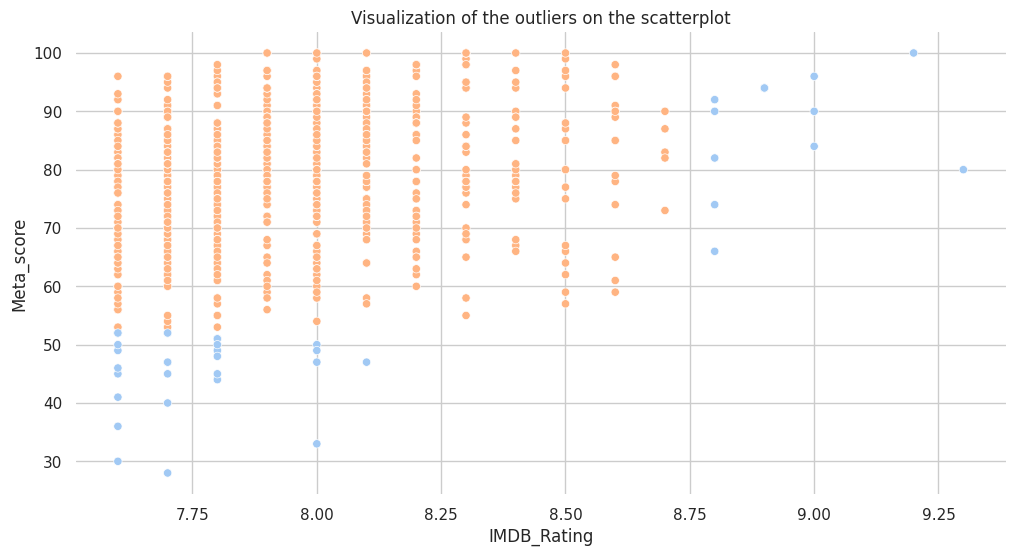

In [151]:
# Creating a list of colors for the plot
colors = list()
for idx in list(df.index):
    if idx not in outliers_idx:
        colors.append("black")
    else:
        colors.append("red")
# Visualization
fig, ax = plt.subplots(figsize = (12,6))
sns.set(style = "whitegrid", palette = "pastel", color_codes = True)
sns.despine(left = True, bottom = True)
sns.scatterplot(data = df, x = "IMDB_Rating", y = "Meta_score", hue = colors, ax = ax, legend = False)
ax.set_title("Visualization of the outliers on the scatterplot")
plt.show()